In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import glob
import sys
cv2.__version__

'4.6.0'

1. Usando a plataforma Kaggle, pesquise um base supervisionada de imagens que possa ser usada para treinar um classificador binário de imagens. Esta base deve conter exemplos de duas classes. Considere 70% das amostras para treino, e 30% para teste (método holdout).

a) Usando OpenCV, extraia descritores HOG (Histogram of Gradients), e treine um classificador SVM. Exiba a acurácia atingida no conjunto de teste e a matriz de confusão. Exiba exemplos. Obs.: note que essa abordagem é semelhante ao detector Dalal-Triggs, porém aqui estamos usando-a para classificação de imagens.

In [2]:
BLOCKSIZE = (16,16)
BLOCKSTRIDE = (4,4)
CELLSIZE = (4,4)
NBINS = 9
DERIVAPERTURE = 1
WINSIGMA = 4.
HISTOGRAMNORMTYPE = 0
L2HYSTHRESHOLD = 2.0000000000000001e-01
GAMMACORRECTION = 0
NLEVELS = 64

classes = ['Cat', 'Dog']
X_image = Y_image = X_features = Y_features = None

for each in classes:
  count = 0
  for img in glob.glob('archive/PetImages/'+each+'/*.jpg'):
    temp = cv2.imread(img)
    if temp is None: continue
    temp = cv2.resize(temp, (128, 128))
    winSize = temp.shape
    if count > 980: break
    count += 1
    
    hog = cv2.HOGDescriptor((128, 128), BLOCKSIZE, BLOCKSTRIDE, CELLSIZE, NBINS, DERIVAPERTURE, WINSIGMA, HISTOGRAMNORMTYPE, L2HYSTHRESHOLD, GAMMACORRECTION, NLEVELS)
    features = hog.compute(temp).transpose()

    if X_image is not None:
      X_image = np.vstack((X_image, [temp]))
      Y_image = np.hstack((Y_image, [each]))
    else:
      X_image = np.array([temp])
      Y_image = np.array([each])
    
    if X_features is not None:
      X_features = np.vstack((X_features, features))
      Y_features = np.hstack((Y_features, [each]))
    else:
      X_features = np.array(features)
      Y_features = np.array([each])
    

X_train, X_test, y_train, y_test = train_test_split(X_features, Y_features, test_size=0.3, random_state=0)
model = SVC(probability=True)
model.fit(X_train, y_train)

print("test accuracy")
model.score(X_test, y_test)

test accuracy


0.7198641765704584

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


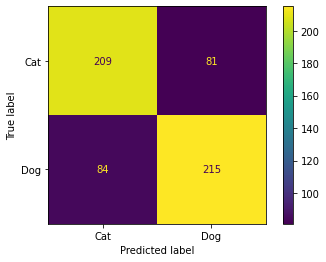

In [3]:
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

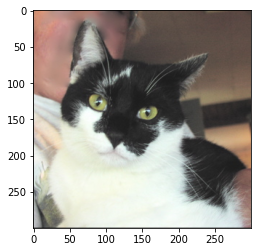

probabilidade: 0.5 gato | 0.5 cachorro


In [4]:
test_img = cv2.imread('archive/PetImages/Cat/999.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()
test_img = cv2.resize(test_img, (128, 128))

hog = cv2.HOGDescriptor((128, 128), BLOCKSIZE, BLOCKSTRIDE, CELLSIZE, NBINS, DERIVAPERTURE, WINSIGMA, HISTOGRAMNORMTYPE, L2HYSTHRESHOLD, GAMMACORRECTION, NLEVELS)
features = hog.compute(test_img).transpose()

prob = model.predict_proba(features.reshape(1, -1))
print(f'probabilidade: {prob[0][0]} gato | {prob[0][1]} cachorro')

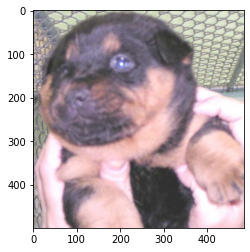

probabilidade: 0.18756789787655243 gato | 0.8124321021234476 cachorro


In [5]:
test_img = cv2.imread('archive/PetImages/Dog/999.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()
test_img = cv2.resize(test_img, (128, 128))

hog = cv2.HOGDescriptor((128, 128), BLOCKSIZE, BLOCKSTRIDE, CELLSIZE, NBINS, DERIVAPERTURE, WINSIGMA, HISTOGRAMNORMTYPE, L2HYSTHRESHOLD, GAMMACORRECTION, NLEVELS)
features = hog.compute(test_img).transpose()

prob = model.predict_proba(features.reshape(1, -1))
print(f'probabilidade: {prob[0][0]} gato | {prob[0][1]} cachorro')

b) Agora o objetivo é treinar uma CNN. Usando a abordagem de transferência de aprendizado (transfer learning), realize treinamentos usando modelos VGG16, ResNet50, e MobileNetV2 pré-treinados. Compare os resultados usando acurácias e matrizes de confusão. Exiba exemplos.

In [6]:
Y_image_new = np.array([1 if x == 'Cat' else 0 for x in Y_image])
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(X_image, Y_image_new, test_size=0.3, random_state=0)

base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(X_train_image, y_train_image, epochs=5, validation_data=(X_test_image, y_test_image))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


43/43 [==============================] - 40s 929ms/step - loss: 1.3738 - binary_accuracy: 0.7881 - val_loss: 0.8991 - val_binary_accuracy: 0.8608
Epoch 2/5
43/43 [==============================] - 40s 939ms/step - loss: 0.5749 - binary_accuracy: 0.8849 - val_loss: 0.7382 - val_binary_accuracy: 0.8812
Epoch 3/5
43/43 [==============================] - 41s 966ms/step - loss: 0.4289 - binary_accuracy: 0.9075 - val_loss: 0.6342 - val_binary_accuracy: 0.8930
Epoch 4/5
43/43 [==============================] - 41s 965ms/step - loss: 0.3125 - binary_accuracy: 0.9257 - val_loss: 0.6041 - val_binary_accuracy: 0.8947
Epoch 5/5
43/43 [==============================] - 41s 957ms/step - loss: 0.2517 - binary_accuracy: 0.9352 - val_loss: 0.5851 - val_binary_accuracy: 0.8998


19/19 [==============================] - 12s 611ms/step


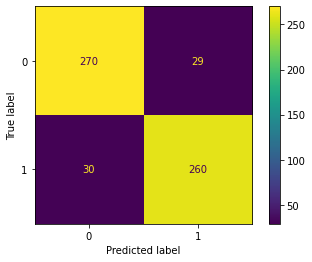

In [7]:
y_prediction = model.predict(X_test_image)
y_prediction = [1 if x > 0.5 else 0 for x in y_prediction]
# 1 -> gato
# 0 -> cachorro
ConfusionMatrixDisplay.from_predictions(y_test_image, y_prediction)  
plt.show()

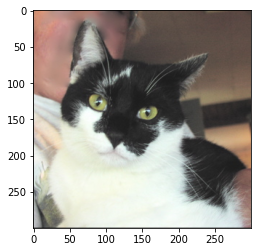

1/1 [==============================] - 0s 44ms/step
probabilidade: 1.0 gato | 0.0 cachorro


In [8]:
temp = cv2.imread('archive/PetImages/Cat/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

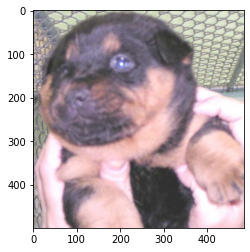

1/1 [==============================] - 0s 43ms/step
probabilidade: 0.9996871948242188 gato | 0.00031280517578125 cachorro


In [9]:
temp = cv2.imread('archive/PetImages/Dog/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

In [10]:
Y_image_new = np.array([1 if x == 'Cat' else 0 for x in Y_image])
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(X_image, Y_image_new, test_size=0.3, random_state=0)

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(X_train_image, y_train_image, epochs=5, validation_data=(X_test_image, y_test_image))


9406464/9406464 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
________________________________________________

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


43/43 [==============================] - 8s 161ms/step - loss: 0.7030 - binary_accuracy: 0.5426 - val_loss: 0.6858 - val_binary_accuracy: 0.5654
Epoch 2/5
43/43 [==============================] - 6s 143ms/step - loss: 0.6350 - binary_accuracy: 0.6344 - val_loss: 0.6705 - val_binary_accuracy: 0.5942
Epoch 3/5
43/43 [==============================] - 6s 142ms/step - loss: 0.6173 - binary_accuracy: 0.6584 - val_loss: 0.6567 - val_binary_accuracy: 0.6027
Epoch 4/5
43/43 [==============================] - 7s 156ms/step - loss: 0.6064 - binary_accuracy: 0.6599 - val_loss: 0.6694 - val_binary_accuracy: 0.6044
Epoch 5/5
43/43 [==============================] - 6s 143ms/step - loss: 0.5922 - binary_accuracy: 0.6883 - val_loss: 0.6513 - val_binary_accuracy: 0.6146


19/19 [==============================] - 2s 98ms/step


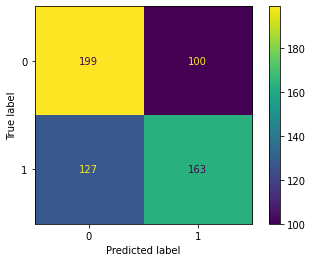

In [11]:
y_prediction = model.predict(X_test_image)
y_prediction = [1 if x > 0.5 else 0 for x in y_prediction]
# 1 -> gato
# 0 -> cachorro
ConfusionMatrixDisplay.from_predictions(y_test_image, y_prediction)  
plt.show()

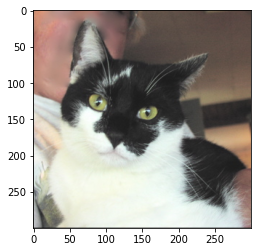

1/1 [==============================] - 0s 18ms/step
probabilidade: 0.7122952342033386 gato | 0.2877047657966614 cachorro


In [12]:
temp = cv2.imread('archive/PetImages/Cat/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

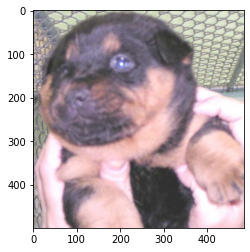

1/1 [==============================] - 0s 17ms/step
probabilidade: 0.5714109539985657 gato | 0.4285890460014343 cachorro


In [13]:
temp = cv2.imread('archive/PetImages/Dog/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

In [14]:
Y_image_new = np.array([1 if x == 'Cat' else 0 for x in Y_image])
X_train_image, X_test_image, y_train_image, y_test_image = train_test_split(X_image, Y_image_new, test_size=0.3, random_state=0)

base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(X_train_image, y_train_image, epochs=5, validation_data=(X_test_image, y_test_image))


94765736/94765736 [==============================] - 11s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/5


c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


43/43 [==============================] - 26s 567ms/step - loss: 0.2979 - binary_accuracy: 0.8631 - val_loss: 0.1535 - val_binary_accuracy: 0.9389
Epoch 2/5
43/43 [==============================] - 24s 573ms/step - loss: 0.1220 - binary_accuracy: 0.9490 - val_loss: 0.1425 - val_binary_accuracy: 0.9372
Epoch 3/5
43/43 [==============================] - 25s 580ms/step - loss: 0.0958 - binary_accuracy: 0.9592 - val_loss: 0.1268 - val_binary_accuracy: 0.9457
Epoch 4/5
43/43 [==============================] - 24s 573ms/step - loss: 0.0777 - binary_accuracy: 0.9701 - val_loss: 0.1276 - val_binary_accuracy: 0.9525
Epoch 5/5
43/43 [==============================] - 25s 590ms/step - loss: 0.0639 - binary_accuracy: 0.9803 - val_loss: 0.1277 - val_binary_accuracy: 0.9508


19/19 [==============================] - 8s 408ms/step


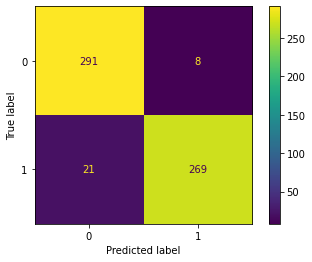

In [15]:
y_prediction = model.predict(X_test_image)
y_prediction = [1 if x > 0.5 else 0 for x in y_prediction]
# 1 -> gato
# 0 -> cachorro
ConfusionMatrixDisplay.from_predictions(y_test_image, y_prediction)  
plt.show()

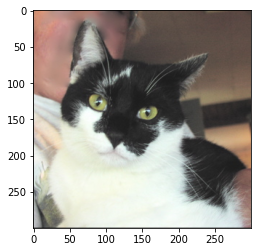

1/1 [==============================] - 0s 39ms/step
probabilidade: 0.9991248846054077 gato | 0.0008751153945922852 cachorro


In [16]:
temp = cv2.imread('archive/PetImages/Cat/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

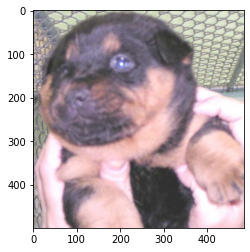

1/1 [==============================] - 0s 38ms/step
probabilidade: 0.0650864914059639 gato | 0.9349135085940361 cachorro


In [17]:
temp = cv2.imread('archive/PetImages/Dog/999.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()
temp = cv2.resize(temp, (128, 128))
temp = np.array([temp])

prob = model.predict(temp)
print(f'probabilidade: {prob[0][0]} gato | {1-prob[0][0]} cachorro')

2. O objetivo dessa questão é criar um rastreador de pessoas em vídeos, usando um modelo pré-treinado da YOLO v5.

In [18]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\pedro/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-7-12 Python-3.10.2 torch-1.11.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


a) Exiba resultados de deteções em três imagens.

Saved 1 image to runs\detect\exp
C:\Users\pedro\AppData\Local\Temp\ipykernel_3852\1442746822.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


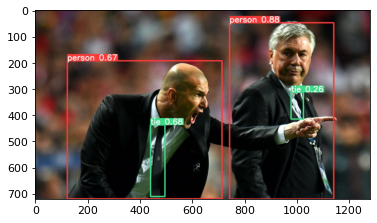

In [19]:
img = 'https://ultralytics.com/images/zidane.jpg'

results = model(img)
results.save(save_dir='runs/detect/exp/')

temp = cv2.imread('runs/detect/exp/zidane.jpg')

temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

Saved 1 image to runs\detect\exp
C:\Users\pedro\AppData\Local\Temp\ipykernel_3852\2252413738.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


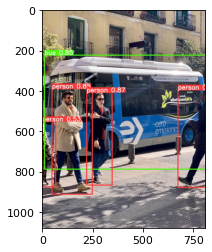

In [20]:
img = 'https://ultralytics.com/images/bus.jpg'

results = model(img)
results.save(save_dir='runs/detect/exp/')

temp = cv2.imread('runs/detect/exp/bus.jpg')

temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

Saved 1 image to runs\detect\exp2
C:\Users\pedro\AppData\Local\Temp\ipykernel_3852\1266398520.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


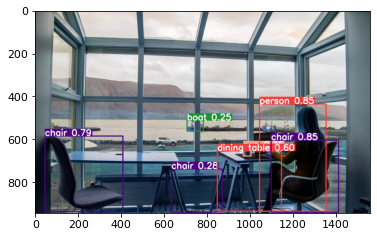

In [21]:
img = cv2.imread('land.jpg')

results = model(img)
results.save(save_dir='runs/detect/exp2')

temp = cv2.imread('runs/detect/exp2/image0.jpg')

temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

b) Aplique o modelo para detectar pessoas em movimento em um vídeo com a câmera estática. Use o centro das bounding boxes de pessoas detectadas em cada quadro do vídeo para desenhar, sobre a primeira imagem do vídeo, uma curva com a trajetória da(s) pessoa(s). O resultado deve ser semelhante ao da imagem abaixo, onde a curva foi desenhada em vermelho.

Can't receive frame (stream end?). Exiting ...
1684 frames


C:\Users\pedro\AppData\Local\Temp\ipykernel_3852\1357343114.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


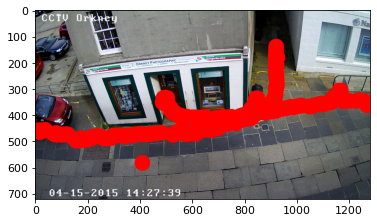

In [22]:
cap = cv2.VideoCapture('static_camera_sample.mp4')

count = 0
first_frame = None

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
  
  if not count: first_frame = frame
  
  results = model(frame)
  for obj in results.xyxy[0]:
    if obj[5] == 0:
      center = (int(((obj[2]-obj[0])/2)+obj[0]), int(((obj[3]-obj[1])/2)+obj[1]))
      cv2.circle(first_frame, center, 30, (0, 0, 255), -1)
  
  count += 1



cap.release()
print(f'{count} frames')
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
plt.imshow(first_frame)
plt.show()